# Move away from lightcone

In [85]:
#%matplotlib qt5
%matplotlib inline
import math
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import eigh
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,10]
np.set_printoptions(precision=4)


In [86]:
#Define the unitary gate 

"""
Unitaries defined as going forward in time, with U(a,b,c,d) given by

-0.5 * 1j * np.exp(1j*np.pi/4.*(a-d)*(c-b))*np.exp(-1j*h_1*(a+c)/2.-1j*h_2*(b+d)/2.)

where a,b,c,d \in {1,-1} (in array-notation {1,0})

a   b
|   |
-----
| U |
-----
|   |
c   d
"""

def dual_unitary_gate():
    J = np.pi/4.
    b = np.pi/4.
    h_1 = 0.2
    h_2 = 0.7
    X = np.array([[0,1], [1, 0]])
    Z = np.array([[1,0], [0, -1]])
    X_exp = np.cos(b) * np.identity(2) - 1j * np.sin(b) * X
    Z_1_exp = np.cos(0.5*h_1) * np.identity(2) - 1j * np.sin(0.5*h_1) * Z
    Z_2_exp = np.cos(0.5*h_2) * np.identity(2) - 1j * np.sin(0.5*h_2) * Z
    
    ZZ = np.einsum("ac,bd->abcd", Z, Z)
    IdId = np.einsum("ac,bd->abcd", np.identity(2), np.identity(2))
    ZZ_exp = np.cos(J) * IdId - 1j * np.sin(J) * ZZ

    K_1 = np.einsum('ab,bc,cd->ad',Z_1_exp,X_exp,Z_1_exp)
    K_2 = np.einsum('ab,bc,cd->ad',Z_2_exp,X_exp,Z_2_exp)
    return np.einsum("abcd,ce,df,efjk", ZZ_exp, K_1, K_2, ZZ_exp)

#Represent unitaries as matrices rather than tensors

def tensor_to_matrix(tensor):
    #Given tensor T_abcd...efgh... returns matrix M_{abcd..., efgh...}
    num_row_indices = len(tensor.shape) // 2
    q = tensor.shape[0]
    return tensor.reshape(2 * [q ** num_row_indices])

def tensor_to_vector(tensor):
    #Given tensor T_abcd... returns vector V_{abcd...}
    num_row_indices = len(tensor.shape) 
    q = tensor.shape[0]
    return tensor.reshape([q ** num_row_indices])


In [87]:
#Define column transfer matrix
U = dual_unitary_gate()
q = 2

A = np.einsum('amse,bnmf,cnog,doth-> abcdefghst',np.conj(U),np.conj(U),U,U)
T = np.einsum('abcdijklst,efghmnopts->abcdefghijklmnop',A,A) / q

In [88]:
#Check eigenvalues
T_mat = tensor_to_matrix(T)
[eig_vals,eig_vecs] = np.linalg.eig(T_mat)
print(np.sort(eig_vals))

[-7.1655e-01-9.2808e-17j -7.1655e-01+2.7756e-17j -7.1655e-01+2.7185e-17j
 -7.1655e-01-2.7701e-16j -6.0768e-01+2.6339e-16j -2.2720e-01-1.8735e-16j
 -2.2720e-01+1.8025e-17j -2.2720e-01+1.5968e-17j -2.2720e-01-3.5605e-16j
 -2.1616e-01+2.1527e-01j -2.1616e-01+2.1527e-01j -2.1616e-01-2.1527e-01j
 -2.1616e-01-2.1527e-01j -2.1616e-01-2.1527e-01j -2.1616e-01+2.1527e-01j
 -2.1616e-01-2.1527e-01j -2.1616e-01+2.1527e-01j -1.7597e-01-2.3896e-16j
 -1.7597e-01-6.0802e-16j -1.7597e-01+1.1471e-16j -1.7597e-01+3.4091e-17j
 -1.7597e-01-1.9299e-17j -1.7597e-01+2.1055e-16j -1.7597e-01-3.2743e-17j
 -1.7597e-01-8.3267e-17j -1.7597e-01+1.5927e-16j -1.7597e-01+3.0813e-16j
 -1.7597e-01+1.3010e-18j -1.7597e-01+3.9552e-16j -1.4123e-01-1.6567e-16j
 -1.4123e-01-2.0925e-16j -1.4123e-01+4.7488e-17j -1.4123e-01+4.2284e-17j
 -1.4123e-01-1.5266e-16j -1.4123e-01-4.8572e-17j -1.4123e-01+4.6838e-17j
 -1.4123e-01-6.7596e-17j -1.4123e-01-2.4300e-17j -1.4123e-01-1.5266e-16j
 -7.5753e-16+3.0721e-17j -6.7905e-16-5.6232e-16j -6

In [89]:
Id = np.array([[1,0], [0,1]])
X = np.array([[0,1], [1, 0]])
Z = np.array([[1,0], [0, -1]])


def right_boundary(op):
    return np.einsum('ha,gb,cf,de->abcdefgh',op,Id,Id,op)

def left_boundary(op):
    return np.einsum('ad,bc,eh,fg->abcdefgh',Id,op,Id,op)


def contract_mv(mat,vec):
    return np.einsum('abcdefghijklmnop,ijklmnop->abcdefgh',mat,vec)

def contract_vv(vec_1,vec_2):
    return np.einsum('abcdefgh,abcdefgh',vec_1,vec_2)

def evol_2(U, op_L, op_R, n_t):
    t_range = np.arange(n_t)
    OTOC_range = np.zeros(n_t,dtype=complex)
    
    q = 2

    A = np.einsum('amse,bnmf,cnog,doth-> abcdefghst',np.conj(U),np.conj(U),U,U)
    T = np.einsum('abcdijklst,efghmnopts->abcdefghijklmnop',A,A) / q
    
    R = right_boundary(op_R)
    L = left_boundary(op_L)
    
    vec_t = R
    for t_i in t_range:
        OTOC_range[t_i] = 1. - contract_vv(L,vec_t) / q**2
        print(OTOC_range[t_i])
        vec_new  = contract_mv(T,vec_t)
        vec_t = vec_new
    return [t_range,OTOC_range]

#print(contract_vv(left_boundary(Id),right_boundary(Id))/ q**2) 

0j
(1.2272020946930875+2.6291902682773483e-17j)
(0.9483792081670733+4.4107782167319275e-18j)
(1.0117283520341567-6.1133990221153756e-18j)
(0.9973352938505418-1.0317928064029237e-17j)
(1.0006054268188986-1.0298048428743501e-17j)
(0.9998624457585629-1.0694228000323467e-17j)
(1.0000312526117883-1.0969604168361818e-17j)
(0.9999928993411369-1.1328114996636643e-17j)
(1.0000016132845675-1.167766477675804e-17j)
(0.9999996334583668-1.2031171007427796e-17j)
(1.0000000832790268-1.238342338884037e-17j)
(0.9999999810788307-1.273585002892891e-17j)
(1.0000000042989292-1.308820089580481e-17j)
(0.9999999990232742-1.3440568763118293e-17j)
(1.000000000221914-1.3792933462896964e-17j)
(0.9999999999495806-1.414529935282578e-17j)
(1.0000000000114553-1.4497665019746775e-17j)
(0.9999999999973971-1.485003074020175e-17j)
(1.000000000000591-1.520239644394931e-17j)
(0.9999999999998656-1.5554762150659007e-17j)
(1.0000000000000304-1.5907127856528776e-17j)
(0.9999999999999928-1.6259493562617256e-17j)
(1.0000000000000

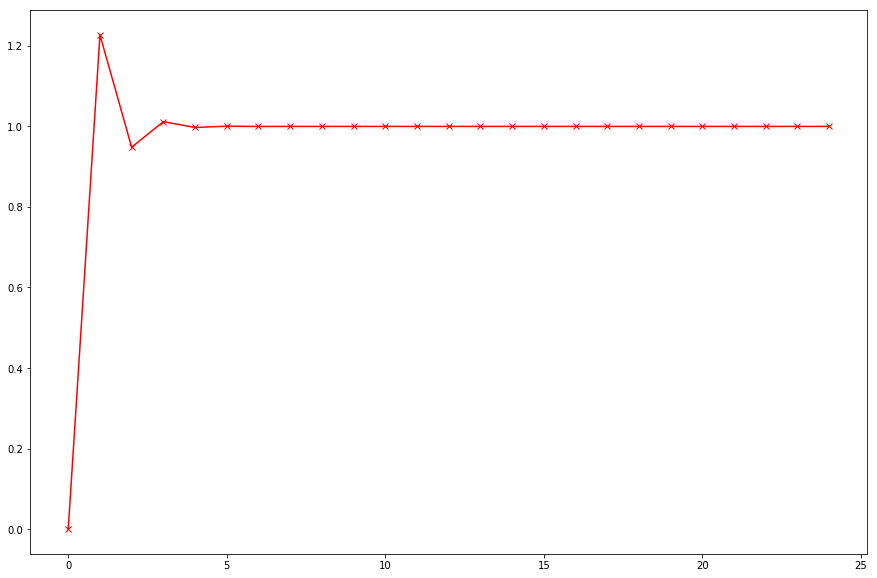

In [119]:
n_t = 25
plt.figure()
[t_range, OTOC_range] = evol_2(U, Z, Z, n_t)
plt.plot(t_range,OTOC_range.real,'rx-')
plt.show()

In [115]:
op_R = Z
op_L = Z

mat_T = tensor_to_matrix(T)
vec_R = tensor_to_vector(right_boundary(op_R))
vec_L = tensor_to_vector(left_boundary(op_L))
n = 20
print(1. - vec_L.dot(np.linalg.matrix_power(mat_T, n)).dot(vec_R)/q**2)

[E_t,V_t] = np.linalg.eig(mat_T)

print("Check hermiticity")
print(np.linalg.norm(mat_T-np.conj(mat_T.T)))

OTOC_ss = 1. - np.sum([vec_L.dot(np.conj(V_t[n_i])) * vec_R.dot(V_t[n_i]) for n_i,e_i in enumerate(E_t) if np.abs(e_i-1.) < 1e-8]) / q**2
print("Steady-state value of the OTOC:", OTOC_ss)

ov_mat = np.array([[np.conj(V_t[n_i]).dot(V_t[n_j]) for n_i,e_i in enumerate(E_t) if np.abs(e_i-1.) < 1e-8] for n_j,e_j in enumerate(E_t) if np.abs(e_j-1.) < 1e-8])

(0.9999999999998651-1.555476215065901e-17j)
Check hermiticity
9.130186458058164
Steady-state value of the OTOC: (0.9458400269241354-0.023526371180946568j)
